In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [4]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [13]:
# pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'
pickle_file = 'data/COX_DATA_FULL_LIVING_EXPERIMENTAL.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [21]:
yes_categorical=[
                "ON_DIALYSIS", 
                "ETHCAT", 
                "ETHCAT_DON",
                'DIAB',
                'LIV_DON_TY',
                "ABO_MAT", 
                'HBV_CORE', 
                'HCV_SEROSTATUS',  # negative importance
                "PRE_TX_TXFUS", # negative importance
                "GENDER", # negative importance
                
            ]
yes_numerical = [   
                # "SERUM_CREAT", # might be data leakage, as it is after the transplant
                "AGE", 
                "AGE_DON",
                "DIALYSIS_TIME",                
                "NPKID", 
                "HGT_CM_CALC",  
                "BMI_DON_CALC",
                "KI_CREAT_PREOP", # negative importance
                ]

In [15]:
dataset[yes_numerical] = dataset[yes_numerical].astype(float)

dataset[yes_numerical].dtypes

SERUM_CREAT      float64
AGE              float64
AGE_DON          float64
DIALYSIS_TIME    float64
NPKID            float64
HGT_CM_CALC      float64
BMI_DON_CALC     float64
dtype: object

In [22]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # maybe it's better to use not ignore
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, yes_numerical),
        ('cat', categorical_transformer, yes_categorical)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
X = pipeline.fit_transform(dataset[yes_categorical + yes_numerical])

# For calculating feature importance
categorical_x = encode_categorical(dataset[yes_categorical])
numerical_x = standardize(dataset[yes_numerical])
X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [18]:
X_train.shape

(42465, 45)

In [30]:
def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(X_test, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(y_train, y_test, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, pred, times)

    print(f"Concordance Uno: {uno_concordance}")
    print(f"IBS: {ibs}")
    print(f"Mean AUC: {mean_auc}")

    return uno_concordance, ibs, mean_auc

In [24]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

# GBSA

In [32]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.2, subsample=0.5, max_depth=4, random_state=0, verbose=1
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

      Iter       Train Loss      OOB Improve   Remaining Time 


         1       60310.9849         200.4216          826.86m
         2       59766.1284         183.9330          663.47m
         3       59258.1937         169.2727          604.36m
         4       59235.4181         147.4785          580.35m
         5       59535.7240         137.2431          561.12m
         6       59711.1900         115.9502          544.19m
         7       59177.8086         105.1847          540.07m
         8       59633.2583          94.5945          544.24m
         9       59505.8846          85.5352          541.50m
        10       60224.5523          77.0831          546.21m
        20       59097.7690          27.1868          592.00m
        30       58592.9880          11.3915          552.08m
        40       58107.5265           4.0157          532.28m
        50       58516.5212           2.5436          518.21m
        60       57407.1238           1.2628          511.26m
        70       57548.5319          -1.1917          507.81m
        

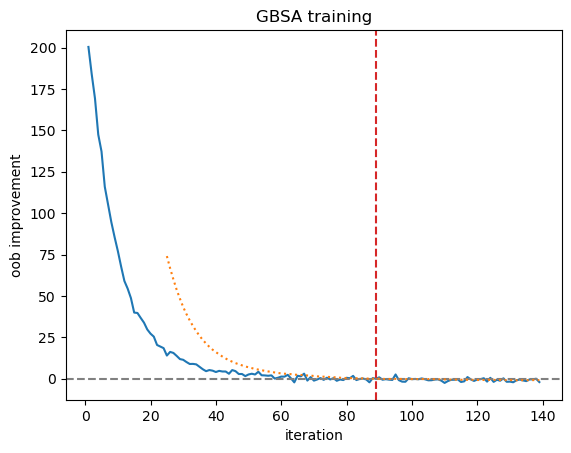

In [38]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_, index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")
ax.title.set_text("GBSA training")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

In [34]:
evaluate_model(est_early_stopping, X_test, y_test, y_train, times)

Concordance Uno: (0.7204980185453689, 13744007, 5411367, 23, 3954)
IBS: 0.13624879306320417
Mean AUC: 0.739827065529256


((0.7204980185453689, 13744007, 5411367, 23, 3954),
 0.13624879306320417,
 0.739827065529256)

In [39]:
from sklearn.inspection import permutation_importance

result = permutation_importance(est_early_stopping, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)


In [40]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X_train.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
print(importances_df)

                    Importance
AGE               1.180354e-01
DIAB=3.0          2.151681e-02
DIAB=5.0          1.239792e-02
DIALYSIS_TIME     1.201799e-02
DIAB=2.0          9.971276e-03
ON_DIALYSIS=Y     5.404182e-03
NPKID             2.279073e-03
ETHCAT=5          1.751872e-03
ETHCAT=4          1.127729e-03
ETHCAT_DON=4.0    1.124795e-03
HGT_CM_CALC       9.974839e-04
BMI_DON_CALC      9.383570e-04
AGE_DON           5.499834e-04
ETHCAT=2          2.426496e-04
ETHCAT_DON=2.0    1.899386e-04
HBV_CORE=ND       1.572925e-04
LIV_DON_TY=2.0    1.253354e-04
ETHCAT=9          7.523989e-05
ETHCAT=6          6.188595e-05
LIV_DON_TY=999.0  5.417533e-05
DIAB=4.0          5.011642e-05
LIV_DON_TY=11.0   4.202210e-05
LIV_DON_TY=8.0    2.497991e-05
ETHCAT_DON=5.0    2.115070e-05
ETHCAT_DON=9.0    1.422054e-05
ETHCAT_DON=6.0    1.211408e-05
ETHCAT=7          7.825471e-06
LIV_DON_TY=9.0    7.804589e-06
ETHCAT_DON=7.0    6.520356e-06
LIV_DON_TY=5.0    2.792947e-06
ABO_MAT=3.0       3.445504e-07
LIV_DON_

In [35]:
import pickle

# it is commented out to avoid saving the wrong model and overwriting the correct one
# pickle_file = 'TrainedModels/GBSA_0.722_lr0.2_leaving_early_stopping.pkl'

# with open(pickle_file, 'wb') as f:
#     pickle.dump(est_early_stopping, f)


# Trained model evaluation

In [11]:
import pickle
import pandas as pd
import numpy as np

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

with open('TrainedModels/GBSA_0.722_lr0.2_leaving_early_stopping.pkl', 'rb') as file:
    best_model = pickle.load(file)

In [ ]:
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score

surv_fn = best_model.predict_survival_function(X_test, return_array=False)

surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)

# plt.figure(figsize=(10,6))
# plt.plot(bs[0], bs[1], marker=",")
# # plt.axhline(ibs, linestyle="--")
# # plt.text(5, 0, "{model}", fontsize=12)
# plt.title("Time-dependent Brier Score for the Random Survival Forest")
# plt.xlabel("days")
# plt.ylabel("time-dependent Brier Score")

In [ ]:
import pickle

with open('pickle/brier/BS_GBSA_LIVING_FINAL.pickle', 'wb') as f:
    pickle.dump(bs, f)


In [ ]:
lower, upper = np.percentile(y_train["Days"], [10, 90])
times = np.arange(lower, upper + 1)
cph_risk_scores = best_model.predict(X_test)
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)

In [ ]:
with open('pickle/AUC/AUC_GBSA_LIVING_FINAL.pickle', 'wb') as f:
    pickle.dump((times, auc, mean_auc), f)